In [95]:
!pip install transformers

## Load Data

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [97]:
df_train = pd.read_csv("/content/drive/MyDrive/train_tweets.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_tweets.csv")

In [98]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [99]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [100]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [101]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [102]:
print(df_train.shape)#2/3 training set

(31962, 3)


In [103]:
print(df_test.shape)#1/3 test set

(17197, 2)


In [104]:
np.sum(df_train.isna())#no NAs in training set

id       0
label    0
tweet    0
dtype: int64

In [105]:
np.sum(df_test.isna())#no NAs in test set

id       0
tweet    0
dtype: int64

### Data processing

In [106]:
# to lowercase
df_train['tweet'] = df_train['tweet'].str.lower()
df_train.head(2)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...


In [107]:
# remove numbers
df_train['tweet'] = df_train['tweet'].astype(str).str.replace(r"\d+", " ")
df_train.head(2)

<ipython-input-107-9b854208cfab>:2: FutureWarning:

The default value of regex will change from True to False in a future version.



,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...


In [108]:
#remove punctuations
import re
r='[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
df_train['tweet'] = df_train['tweet'].apply(lambda tweet: re.sub(r, '', tweet))

In [109]:
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i cant use ca...


In [110]:
# remove whitespaces
df_train['tweet'] = df_train['tweet'].str.strip()
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [111]:
# remove non_ascii characters
df_train['tweet'] = df_train['tweet'].apply(
                    lambda x: x.encode("ascii", errors="ignore").decode()
                )
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [112]:
# remove html characters
df_train['tweet'] = df_train['tweet'].str.replace(r"<[^<>]*>", "", regex=True)
df_train.head(2)

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...


In [113]:
# tokenization
import nltk
nltk.download('punkt')
df_train['tweet'] = df_train['tweet'].apply(word_tokenize)
df_train.head(2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet
0,1,0,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,"[user, user, thanks, for, lyft, credit, i, can..."


In [114]:
# remove stop words
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
df_train['tweet'] = df_train['tweet'].apply(
                    lambda tokens: [
                        token for token in tokens if token not in stop_words
                    ]
                )
df_train.head(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,label,tweet
0,1,0,"[user, father, dysfunctional, selfish, drags, ..."
1,2,0,"[user, user, thanks, lyft, credit, cant, use, ..."


In [115]:
# stemming
stemmer = PorterStemmer()
df_train['tweet'] = df_train['tweet'].apply(
                    lambda tokens: [stemmer.stem(token) for token in tokens]
                )
df_train.head(2)

,id,label,tweet
0,1,0,"[user, father, dysfunct, selfish, drag, kid, d..."
1,2,0,"[user, user, thank, lyft, credit, cant, use, c..."


In [116]:
# rejoin
df_train['tweet'] = df_train['tweet'].str.join(" ")
df_train.head(2)

,id,label,tweet
0,1,0,user father dysfunct selfish drag kid dysfunct...
1,2,0,user user thank lyft credit cant use caus dont...


In [117]:
from collections import Counter

# Concatenate all the rows in the 'tweet' column into a single string
all_tweets = ' '.join(df_train['tweet'])

# Split the string into words and count the frequency of each word
word_counts = Counter(all_tweets.split())

# Display the word frequencies
for word, count in word_counts.most_common(25):
    print(word, count)

user 17502
love 3144
day 2817
happi 2084
amp 1612
thank 1542
get 1258
time 1238
like 1223
im 1158
u 1157
life 1148
go 1146
today 1085
posit 991
new 987
make 980
father 925
smile 898
peopl 886
bihday 869
good 869
see 865
one 838
cant 813


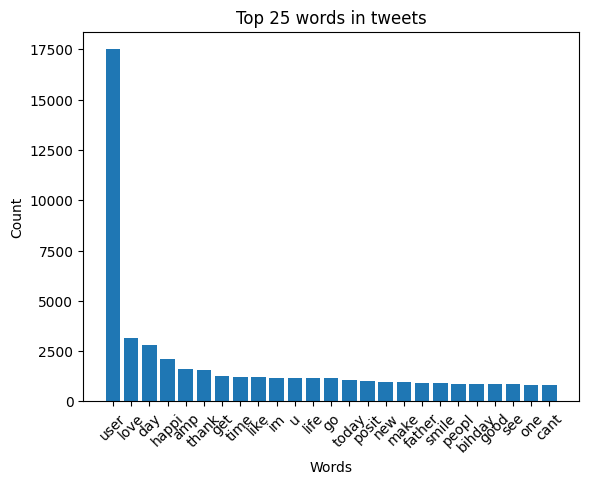

In [118]:
import matplotlib.pyplot as plt

# Get the N most common words and their counts
N = 25
top_words = word_counts.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
words, counts = zip(*top_words)

# Create a bar plot
plt.bar(words, counts)

# Add title and labels
plt.title('Top {} words in tweets'.format(N))
plt.xlabel('Words')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()



In [119]:
# Count the number of each label
label_counts = df_train['label'].value_counts()

# Get the number of label 1
num_label_1 = label_counts[1]

# Get the total number of labels
total_labels = len(df_train)

# Calculate the percentage
percentage_label_1 = (num_label_1 / total_labels) * 100

print("Number of label 1: ", num_label_1)
print("Percentage of hate speech in training set is: ", percentage_label_1, "%")


Number of label 1:  2242
Percentage of hate speech in training set is:  7.014579813528565 %


## Vectorization

### TFIDF to vectorize

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500)#500 features
content_vectors = vectorizer.fit_transform(df_train['tweet'].values.astype('U'))#change to unicode, then fit
content_vectors_array = content_vectors.toarray()#convert to array
tweet_vectors_tfidf = pd.DataFrame(content_vectors_array)
tweet_vectors_tfidf.head(2)


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word2Vec to vectorize

In [121]:
from gensim.models import Word2Vec
import nltk

sentenses = df_train['tweet'].apply(nltk.word_tokenize)

In [122]:
#train the Word2vec model
model = Word2Vec(sentenses,vector_size=500, window=5, min_count=1, workers=4)#500 features

In [123]:
def get_text_vector(model, text):
    words = nltk.word_tokenize(text)#tokenize
    word_vectors = [model.wv[word] for word in words if word in model.wv]#convert to vectors

    if not word_vectors:
        return np.zeros(model.vector_size)#if all words not in model.wv,return 0 for each dimension
    return np.mean(word_vectors, axis=0)#average the vectors

tweet_vectors_word2vec = df_train['tweet'].apply(lambda x: get_text_vector(model, x))


In [124]:
tweet_vectors_word2vec = pd.DataFrame(tweet_vectors_word2vec)
tweet_vectors_word2vec.head(2)

,tweet
0,"[0.19463812, 0.23195179, 0.19255309, 0.1761401..."
1,"[0.18566336, 0.16436766, 0.16372623, 0.2438129..."


## BERT to vectorize

In [125]:
from transformers import BertModel, BertTokenizer
import torch

# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# If there's a GPU available...
if torch.cuda.is_available():

    #Use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# move the model to the GPU
model = model.to(device)

# Define a function to encode text
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
    # Take the vector corresponding to the [CLS] token as the sentence representation
    sentence_vector = outputs[0][0, 0].cpu().numpy() #move tensor to cpu then convert to numpy
    return sentence_vector


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [126]:
# split into 5 batchs
num_batches = 5
batches = np.array_split(df_train, num_batches)


tweet_vectors_BERT = []

for i, batch in enumerate(batches):
    print(f"Processing batch {i+1}/{num_batches}")
    # encode batches
    batch_vectors = batch['tweet'].apply(encode_text)
    tweet_vectors_BERT.extend(batch_vectors)

tweet_vectors_BERT = pd.DataFrame(tweet_vectors_BERT)
print(tweet_vectors_BERT)#dimension = 768

Processing batch 1/5
Processing batch 2/5
Processing batch 3/5
Processing batch 4/5
Processing batch 5/5
            0         1         2         3         4         5         6    \
0     -0.386235  0.066184 -0.103589 -0.189652 -0.303150 -0.156460  0.450781   
1     -0.268751  0.070018  0.071715 -0.129258 -0.039266 -0.265169  0.543793   
2     -0.849660  0.354844 -0.534522  0.001420 -0.586002  0.448913  0.594105   
3     -0.328738  0.055684  0.019677 -0.056584 -0.264892 -0.005369  0.793279   
4     -0.019981 -0.024188 -0.086438 -0.100586  0.027942 -0.278598  0.108005   
...         ...       ...       ...       ...       ...       ...       ...   
31957 -0.202192  0.192212  0.045717 -0.089432 -0.324905 -0.135017  0.381750   
31958 -0.251574  0.158288  0.044507 -0.041987 -0.425812  0.018285  0.354562   
31959 -0.037487  0.038188 -0.021980 -0.545577 -0.533912 -0.284397  0.543170   
31960 -0.202919 -0.052831 -0.070516 -0.467227 -0.424013  0.046555  0.525880   
31961  0.067139  0.217213 

## Exploratary Data Analysis

### 1. Length of tweets

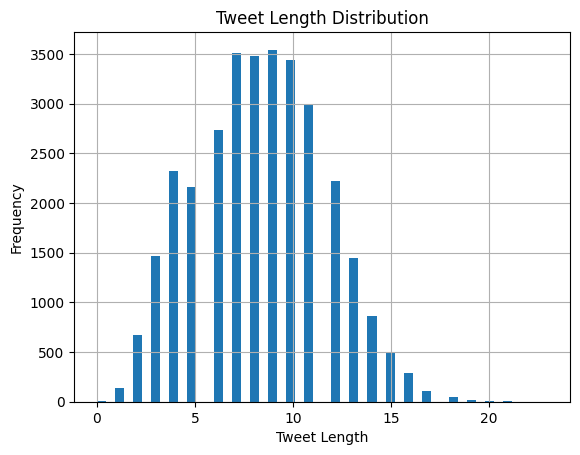

In [127]:
df_train['length_tweet'] = df_train['tweet'].apply(lambda x: len(x.split()))
df_train['length_tweet'].describe()
df_train['length_tweet'].hist(bins=50)

plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


### 2. Analysis of Common Words

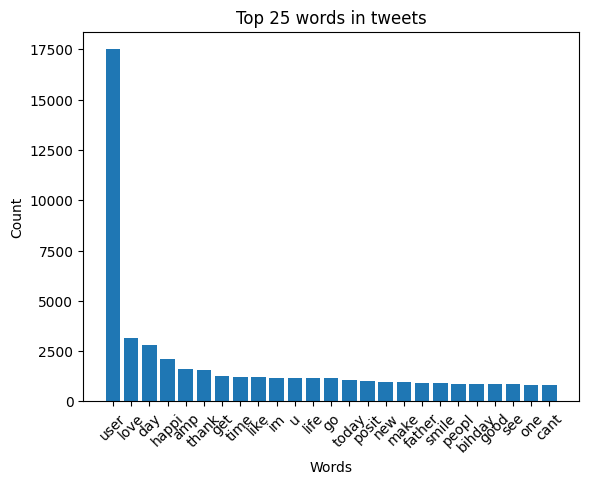

In [128]:
# Get the N most common words and their counts
N = 25
top_words = word_counts.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
words, counts = zip(*top_words)

# Create a bar plot
plt.bar(words, counts)

# Add title and labels
plt.title('Top {} words in tweets'.format(N))
plt.xlabel('Words')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [129]:
from nltk import ngrams

bigrams = [bigram for tweet in df_train['tweet'] for bigram in ngrams(word_tokenize(tweet), 2)]
# Get the frequency of each bigram
bigram_freq = Counter(bigrams)

print(bigram_freq.most_common(10))


[(('user', 'user'), 4201), (('father', 'day'), 643), (('thank', 'posit'), 404), (('posit', 'affirm'), 352), (('love', 'u'), 346), (('cant', 'wait'), 335), (('u', 'take'), 327), (('take', 'u'), 326), (('u', 'time'), 326), (('model', 'love'), 325)]


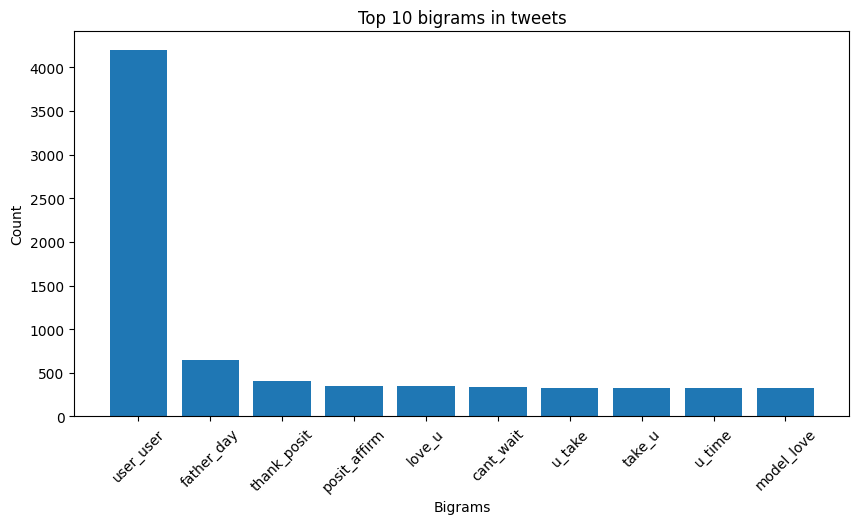

In [130]:
# Get the N most common bigrams and their counts
N = 10
top_bigrams = bigram_freq.most_common(N)

# Split the list of tuples into two lists: one for words and one for counts
bigrams, bigram_counts = zip(*top_bigrams)

# Convert each bigram to a string and join them with an underscore
bigrams_str = ["_".join(bigram) for bigram in bigrams]

# Create a bar plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.bar(bigrams_str, bigram_counts)

# Add title and labels
plt.title('Top {} bigrams in tweets'.format(N))
plt.xlabel('Bigrams')
plt.ylabel('Count')

# Rotate the X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

### 3.Categories of mood

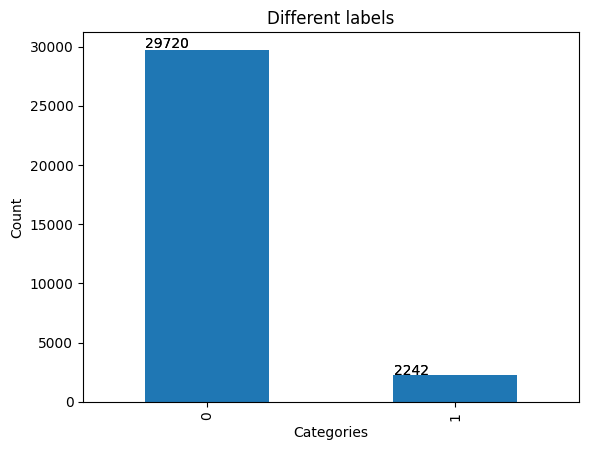

In [139]:
ax = df_train['label'].value_counts().plot(kind='bar')
df_train['label'].value_counts().plot(kind='bar')
plt.title('Different labels'.format(N))
plt.xlabel('Categories')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()#0 means normal speech and 1 means hate speech

### 4.Word clouds

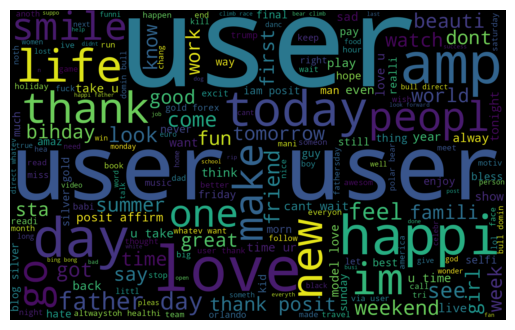

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=1600, height=1000).generate(' '.join(df_train['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

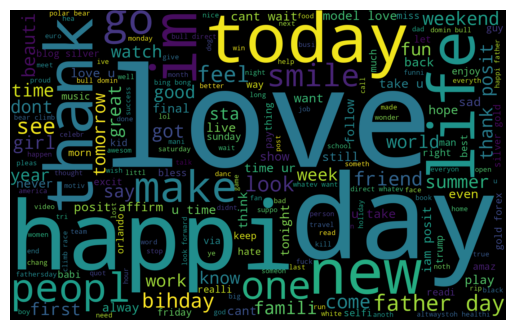

In [133]:
#Without 'user'

# Define a set of stopwords
stopwords = set(STOPWORDS)
stopwords.add('user')  # Add 'user' to the set of stopwords
stopwords.add('amp')
# Generate word cloud
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=1000).generate(' '.join(df_train['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

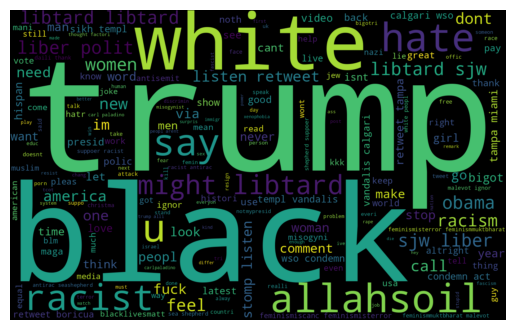

In [134]:
#Word cloud of hate speeches
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=1000).generate(' '.join(df_train[df_train['label'] == 1]['tweet']))

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 5.Explore topics

#### 5.1 All tweets

In [135]:
##all the tweets
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# new stopwords list
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(['user', 'amp'])


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(df_train['tweet'])

#LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm)

# top 10 words
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for hate speech Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for hate speech Topic #0
['look', 'dad', 'fathersday', 'today', 'life', 'bihday', 'love', 'father', 'happi', 'day']


Top 10 words for hate speech Topic #1
['na', 'home', 'know', 'dont', 'model', 'im', 'ur', 'wait', 'love', 'time']


Top 10 words for hate speech Topic #2
['sex', 'live', 'season', 'want', 'place', 'black', 'climb', 'polar', 'race', 'bear']


Top 10 words for hate speech Topic #3
['today', 'alway', 'bless', 'nice', 'grate', 'love', 'iam', 'affirm', 'posit', 'thank']


Top 10 words for hate speech Topic #4
['think', 'morn', 'dont', 'friday', 'good', 'make', 'peopl', 'weekend', 'feel', 'like']


Top 10 words for hate speech Topic #5
['friday', 'friend', 'fun', 'cute', 'beauti', 'happi', 'follow', 'work', 'smile', 'love']


Top 10 words for hate speech Topic #6
['bing', 'im', 'beach', 'peopl', 'good', 'shoot', 'sun', 'trump', 'orlando', 'summer']


Top 10 words for hate speech Topic #7
['im', 'ye', 'use', 'tweet', 'way', 'final', 'forex', 'silver', 'gold', 'blo

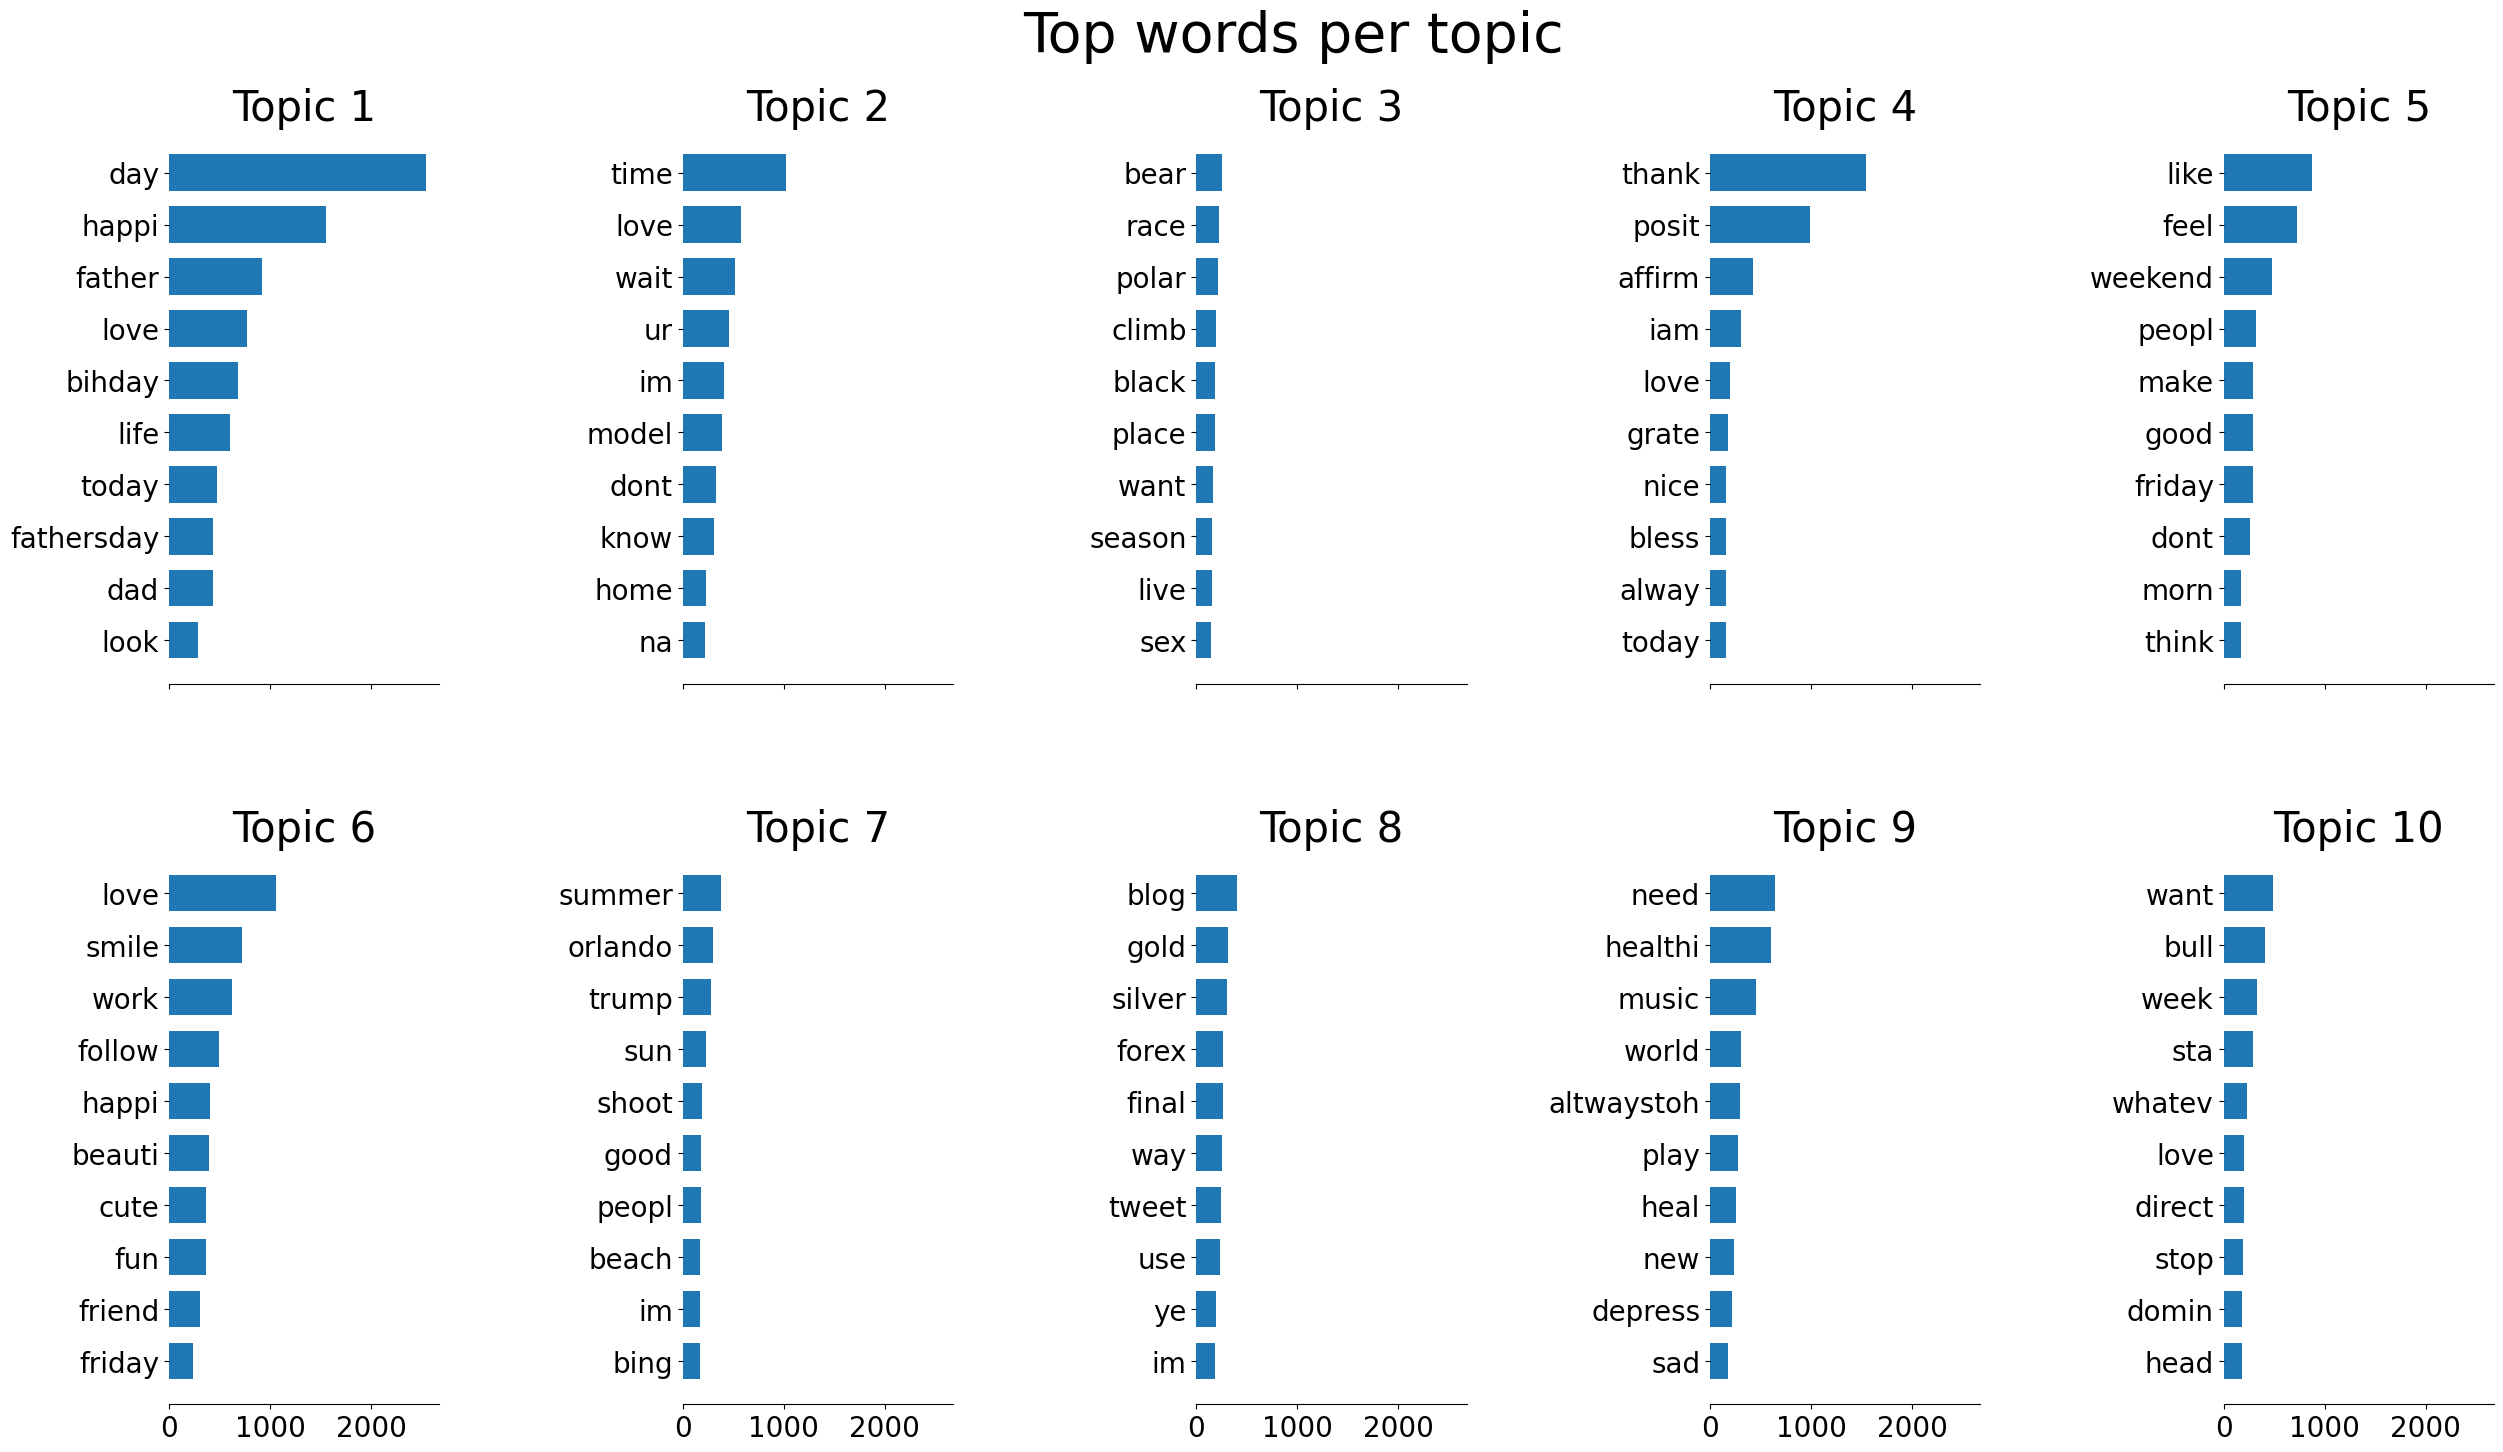

In [136]:
## plot of the common words for all tweets
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words per topic', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)

#### 5.2 Hate speech

In [137]:
##hate speech
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# create a new stopwords list
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(['user', 'amp'])

# vectorize
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = vectorizer.fit_transform(df_train[df_train['label'] == 1]['tweet'])

# implement LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm)

# top 10 words
for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for hate speech Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')


Top 10 words for hate speech Topic #0
['word', 'racism', 'way', 'doesnt', 'peopl', 'man', 'dont', 'race', 'black', 'white']


Top 10 words for hate speech Topic #1
['color', 'death', 'love', 'dont', 'allahsoil', 'think', 'god', 'peopl', 'hate', 'need']


Top 10 words for hate speech Topic #2
['equal', 'believ', 'world', 'pay', 'comment', 'right', 'sjw', 'polit', 'liber', 'libtard']


Top 10 words for hate speech Topic #3
['white', 'hispan', 'tampa', 'miami', 'stomp', 'black', 'listen', 'retweet', 'feel', 'like']


Top 10 words for hate speech Topic #4
['messag', 'thing', 'say', 'terror', 'word', 'black', 'men', 'woman', 'allahsoil', 'women']


Top 10 words for hate speech Topic #5
['maga', 'misogyni', 'arent', 'bigotri', 'bigot', 'peopl', 'hatr', 'im', 'new', 'trump']


Top 10 words for hate speech Topic #6
['say', 'kkk', 'school', 'daili', 'stop', 'peopl', 'latest', 'thank', 'trump', 'white']


Top 10 words for hate speech Topic #7
['say', 'wso', 'templ', 'vandalis', 'ignor', 'condemn

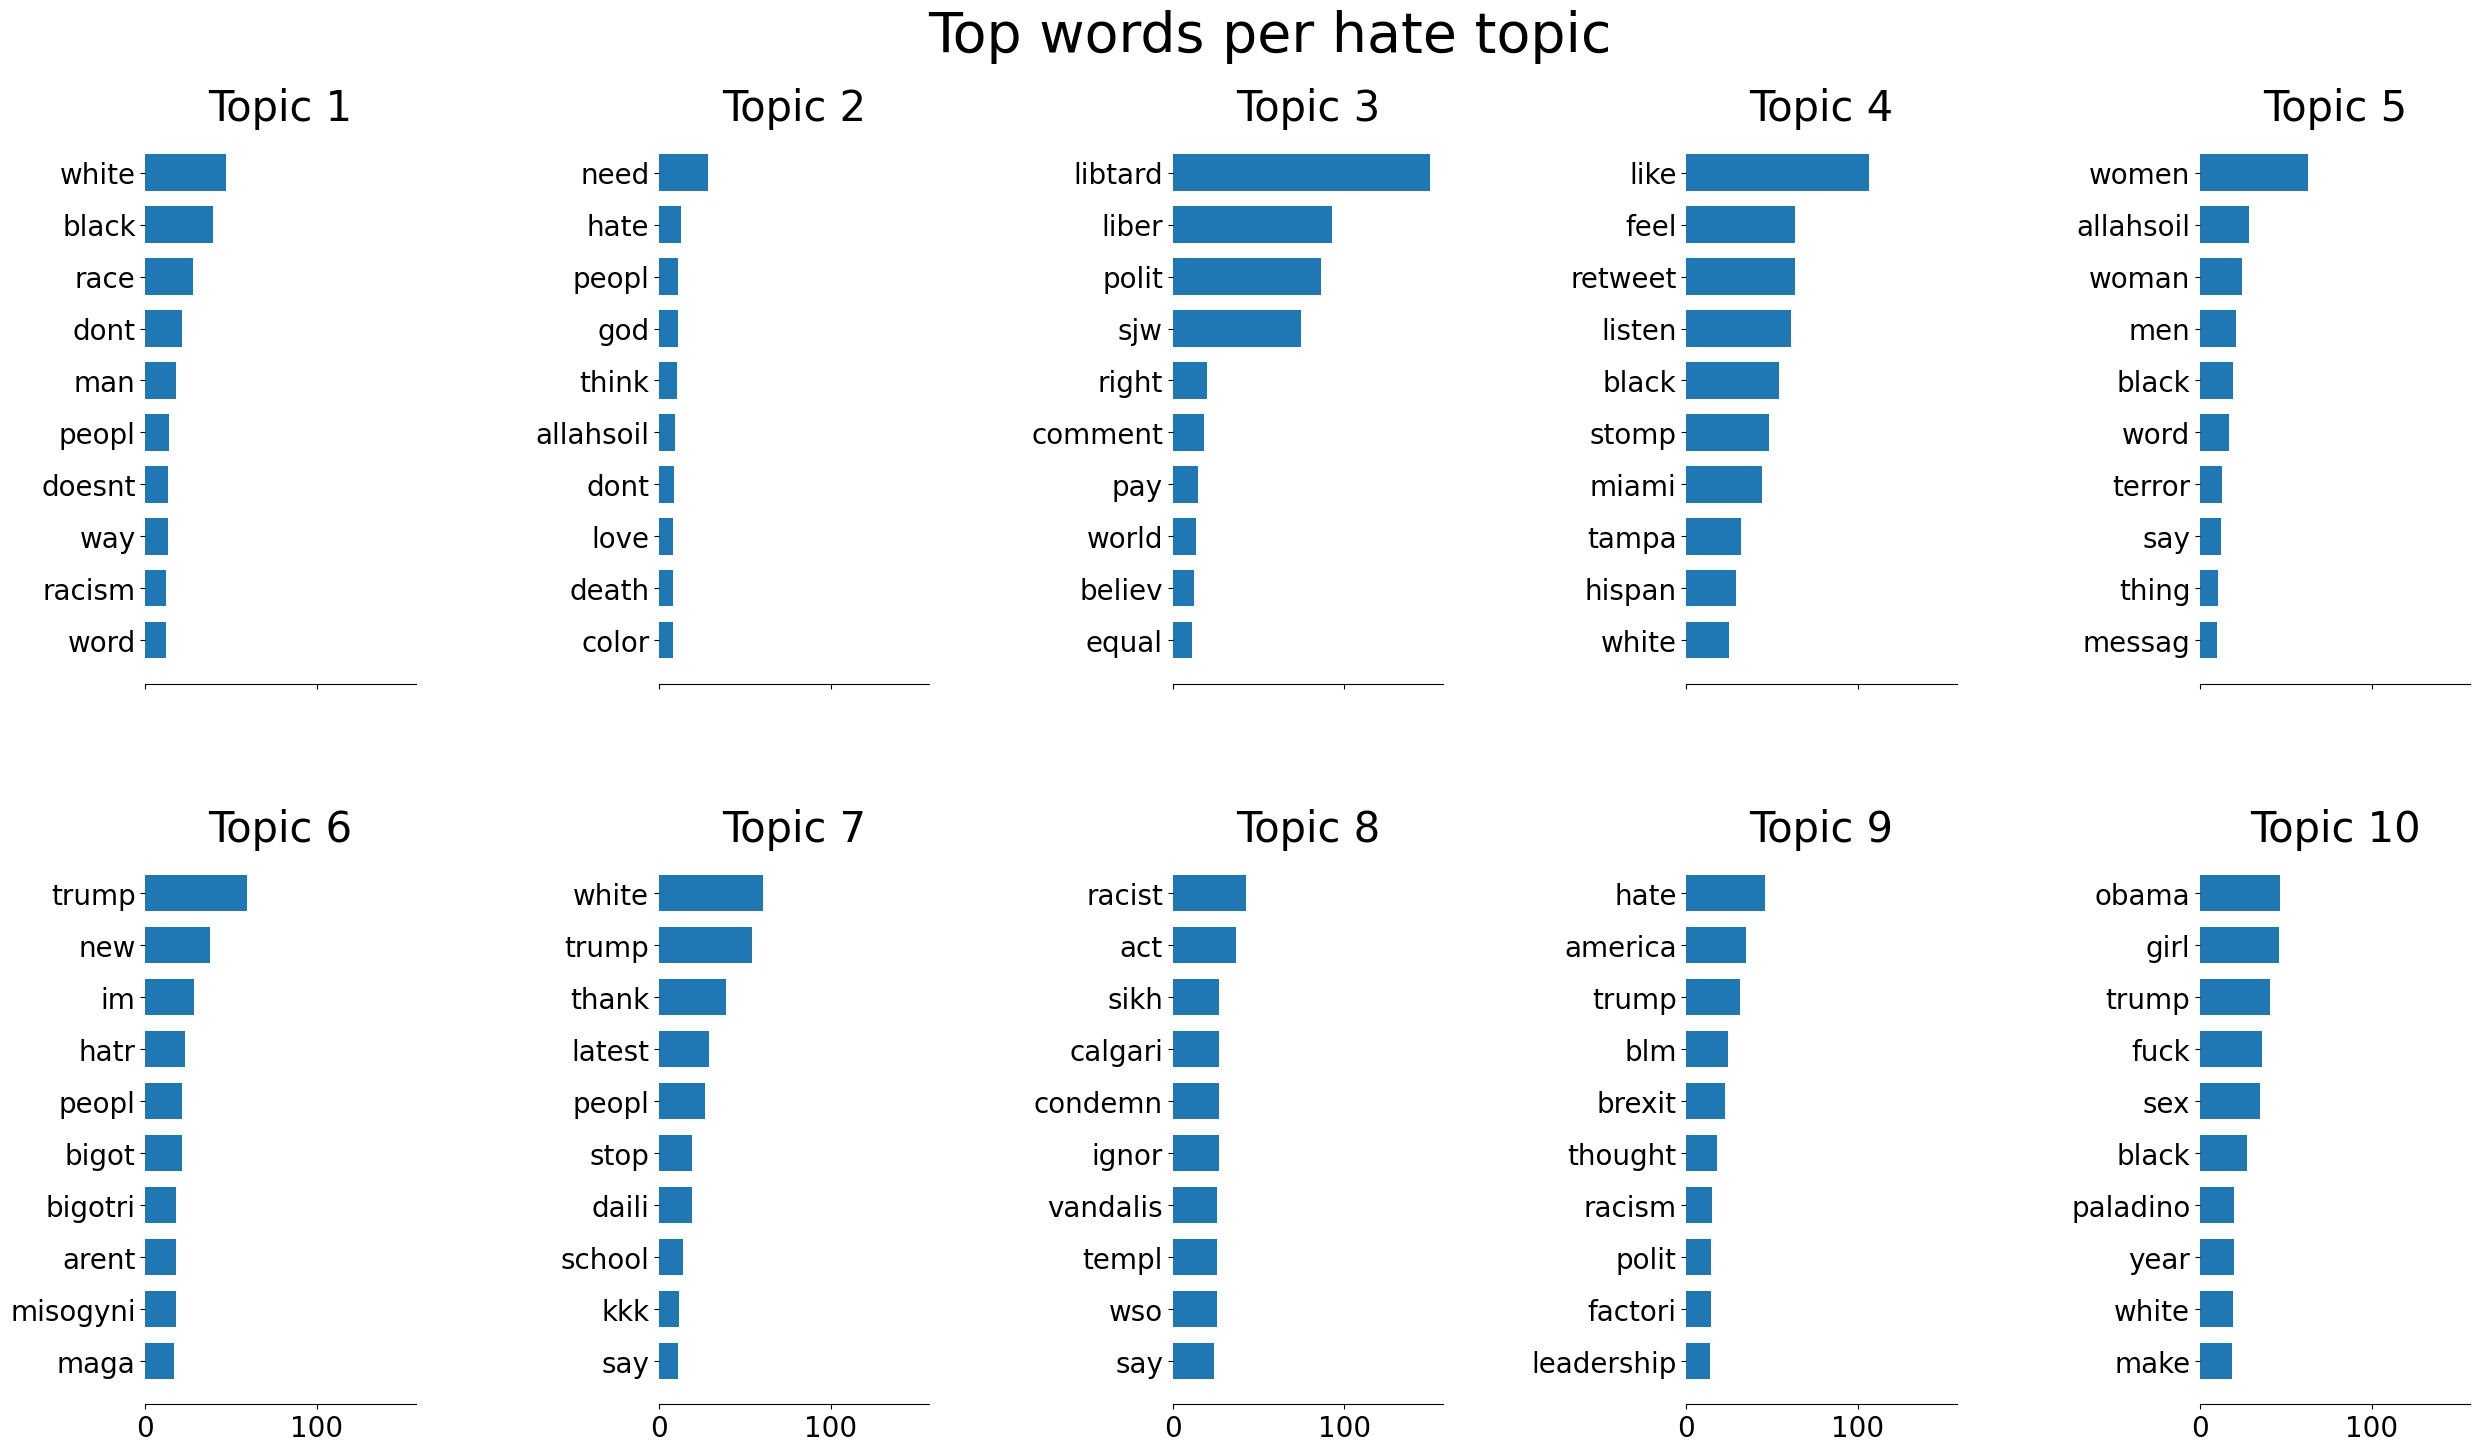

In [138]:
## plot of the common words for hate speech
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Top words per hate topic', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, n_top_words)